In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
!pip install yfinance --upgrade --no-cache-dir

In [ ]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df = pdr.get_data_yahoo("LT.NS", start="2022-01-03", end="2024-02-25").reset_index()
df.to_csv('/content/LT.csv',index=False)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
1,2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747070,1643920
2,2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
3,2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
4,2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123


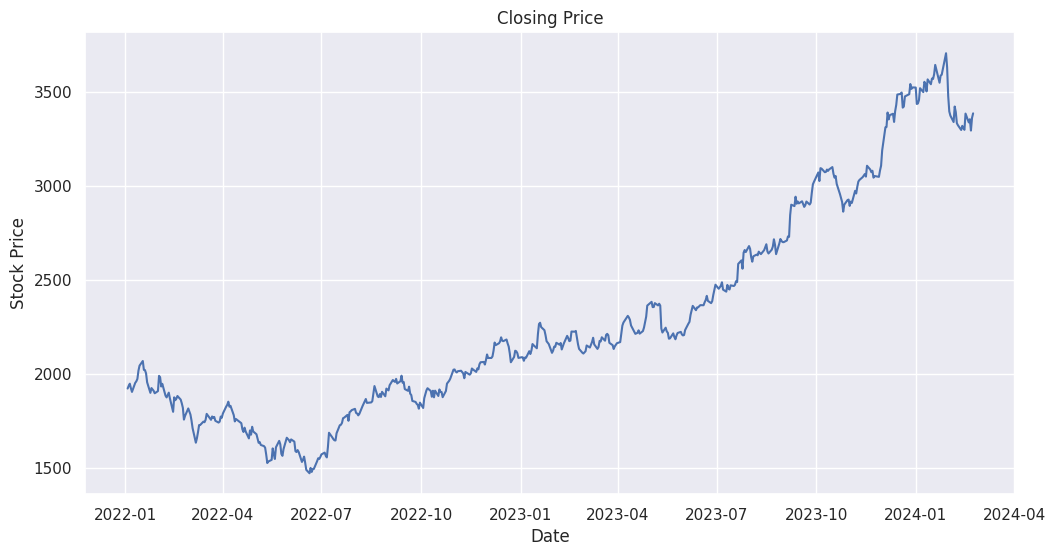

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Closing Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [ ]:
df = pd.read_csv('/content/LT.csv')

### Policy Gradient agent

In [ ]:
import tensorflow as tf
name = 'Policy Gradient agent'
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r

    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))


            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
close = df.Close.values.tolist()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 600, checkpoint = 30, initial_money = initial_money)

<ipython-input-6-0dc68c16d92b>:19: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
<ipython-input-6-0dc68c16d92b>:20: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
<ipython-input-6-0dc68c16d92b>:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-

epoch: 30, total rewards: 2575.950684.3, cost: -4093.564209, total money: 12575.950684
epoch: 60, total rewards: 2286.400757.3, cost: -4366.705566, total money: 12286.400757
epoch: 90, total rewards: 733.651611.3, cost: -4890.543945, total money: 10733.651611
epoch: 120, total rewards: 2921.200439.3, cost: -5158.428223, total money: 12921.200439
epoch: 150, total rewards: 1806.350952.3, cost: -5337.437500, total money: 11806.350952
epoch: 180, total rewards: 1849.101440.3, cost: -5799.491211, total money: 11849.101440
epoch: 210, total rewards: 2171.701050.3, cost: -4110.857422, total money: 12171.701050
epoch: 240, total rewards: 2374.001587.3, cost: -5981.620605, total money: 12374.001587
epoch: 270, total rewards: 2266.200928.3, cost: -5167.216309, total money: 12266.200928
epoch: 300, total rewards: 1913.800903.3, cost: -4485.590332, total money: 11913.800903
epoch: 330, total rewards: 2567.650635.3, cost: -5684.708008, total money: 12567.650635
epoch: 360, total rewards: 1583.5516

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 1922.849976, total balance 8077.150024
day 2: buy 1 unit at price 1948.599976, total balance 6128.550049
day 6: buy 1 unit at price 1961.150024, total balance 4167.400024
day 7: buy 1 unit at price 1974.199951, total balance 2193.200073
day 9: buy 1 unit at price 2044.750000, total balance 148.450073
day 14, sell 1 unit at price 1956.050049, investment 1.726608 %, total balance 2104.500122,
day 16, sell 1 unit at price 1925.300049, investment -1.195727 %, total balance 4029.800171,
day 17, sell 1 unit at price 1910.849976, investment -2.564824 %, total balance 5940.650146,
day 18: buy 1 unit at price 1897.550049, total balance 4043.100098
day 21: buy 1 unit at price 1982.699951, total balance 2060.400146
day 24, sell 1 unit at price 1884.500000, investment -4.543610 %, total balance 3944.900146,
day 26, sell 1 unit at price 1888.800049, investment -7.626847 %, total balance 5833.700195,
day 27: buy 1 unit at price 1901.000000, total balance 3932.700195
day 28

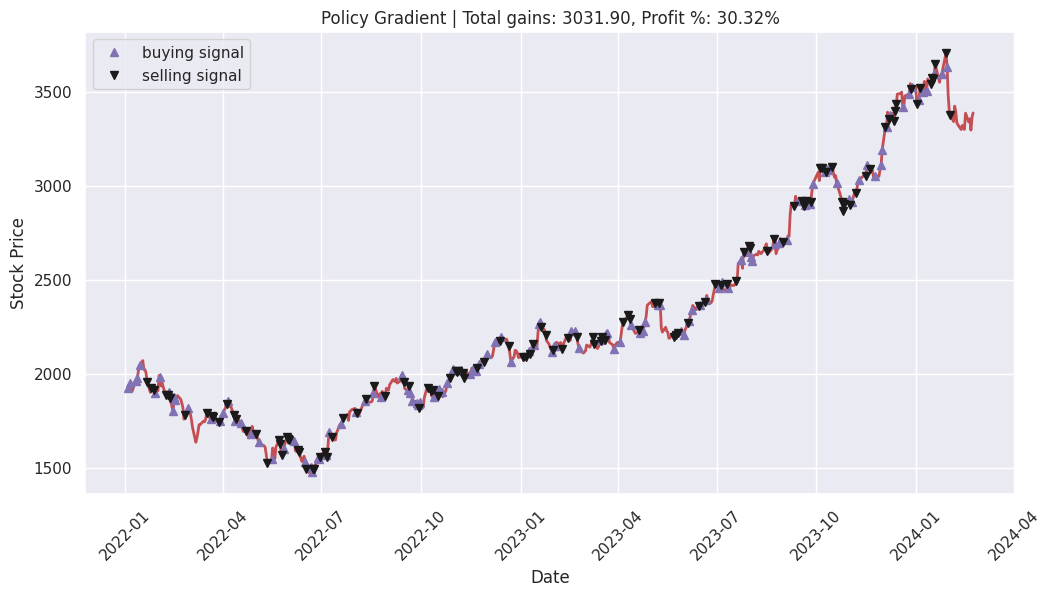

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]
plt.figure(figsize=(12, 6))
plt.plot(date, close, color='r', lw=2.)

# Plot markers for buying and selling signals
plt.plot(date[states_buy], close[states_buy], '^', markersize=6, color='m', label='buying signal')
plt.plot(date[states_sell], close[states_sell], 'v', markersize=6, color='k', label='selling signal')

plt.title('Policy Gradient | Total gains: %.2f, Profit %%: %.2f%%' % (total_gains, invest))

# Set the locator for x-axis ticks to show dates every three months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
df = pd.read_csv('/content/LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]

# Initialize variables for tracking monthly profits
monthly_profits = {}

# Loop through buying and selling signals to calculate profits
for buy_date, sell_date in zip(date[states_buy], date[states_sell]):
    # Extract year and month from the buy date
    year = buy_date.year
    month = buy_date.month

    # Calculate profit for the current trade and add to monthly_profits
    buy_price = close[date == buy_date].values[0]
    sell_price = close[date == sell_date].values[0]
    trade_profit = sell_price - buy_price

    # Add the trade profit to the corresponding month
    if year not in monthly_profits:
        monthly_profits[year] = {}
    if month not in monthly_profits[year]:
        monthly_profits[year][month] = []
    monthly_profits[year][month].append(trade_profit)

# Calculate and print average profit for each month, sorted by year and month
for year in sorted(monthly_profits):
    for month in sorted(monthly_profits[year]):
        profits = monthly_profits[year][month]
        average_profit = sum(profits) / len(profits)
        print(f"Year {year}, Month {month}: Average Profit: {average_profit:.2f}")

Year 2022, Month 1: Average Profit: -52.06
Year 2022, Month 2: Average Profit: -92.05
Year 2022, Month 3: Average Profit: -12.62
Year 2022, Month 4: Average Profit: -153.08
Year 2022, Month 5: Average Profit: 62.07
Year 2022, Month 6: Average Profit: -14.12
Year 2022, Month 7: Average Profit: 0.72
Year 2022, Month 8: Average Profit: 13.46
Year 2022, Month 9: Average Profit: 22.21
Year 2022, Month 10: Average Profit: 69.01
Year 2022, Month 11: Average Profit: 57.76
Year 2022, Month 12: Average Profit: -22.06
Year 2023, Month 1: Average Profit: -4.65
Year 2023, Month 2: Average Profit: 7.76
Year 2023, Month 3: Average Profit: 79.34
Year 2023, Month 4: Average Profit: 47.56
Year 2023, Month 5: Average Profit: -35.45
Year 2023, Month 6: Average Profit: 141.95
Year 2023, Month 7: Average Profit: 142.39
Year 2023, Month 8: Average Profit: 200.75
Year 2023, Month 9: Average Profit: 131.05
Year 2023, Month 10: Average Profit: -101.35
Year 2023, Month 11: Average Profit: 110.69
Year 2023, Month

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
df = pd.read_csv('/content/LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]

# Initialize variables for tracking trades and profits
total_trades = 0
total_profit = 0
monthly_profits = {}
current_month = None

# Loop through buying and selling signals to calculate trades and profits
for buy_date, sell_date in zip(date[states_buy], date[states_sell]):
    # Extract year and month from the buy date
    year = buy_date.year
    month = buy_date.month

    # Calculate profit for the current trade and add to total_profit
    buy_price = close[date == buy_date].values[0]
    sell_price = close[date == sell_date].values[0]
    trade_profit = sell_price - buy_price
    total_profit += trade_profit
    total_trades += 1

    # Add the trade profit to the corresponding month
    if year not in monthly_profits:
        monthly_profits[year] = {}
    if month not in monthly_profits[year]:
        monthly_profits[year][month] = []
    monthly_profits[year][month].append(trade_profit)

# Calculate and print metrics
average_profit_per_trade = total_profit / total_trades
annualized_return = (1 + total_profit / 100) ** (12 / len(date.dt.to_period("M").unique())) - 1

print(f"Total Trades: {total_trades}")
print(f"Total Profit: {total_profit:.2f}")
print(f"Average Profit per Trade: {average_profit_per_trade:.2f}")
print(f"Annualized Return: {annualized_return * 100:.2f}%")

Total Trades: 121
Total Profit: 3031.90
Average Profit per Trade: 25.06
Annualized Return: 390.20%


In [ ]:
#Calculate performance metrics
def calculate_metrics(states_buy, states_sell, close_prices, initial_money):
    total_gains = total_profit

    # Calculate ROI based on initial investment
    ROI_initial_investment = (total_gains / initial_money) * 100

    # Calculate ROI based on total transactions
    total_investment = initial_money
    for buy_index in states_buy:
        total_investment -= close_prices[buy_index]
    for sell_index in states_sell:
        total_investment += close_prices[sell_index]
    ROI_total_investment = ((close_prices[-1] - total_investment) / total_investment) * 100

    # Calculate Sharpe Ratio (assuming risk-free rate is 0)
    returns = np.diff(close_prices) / close_prices[:-1]
    sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)

    # Calculate maximum drawdown
    max_drawdown = np.max(np.maximum.accumulate(close_prices) - close_prices) / np.max(np.maximum.accumulate(close_prices))

    # Calculate winning trades percentage
    winning_trades = len(states_sell) / (len(states_buy) + len(states_sell)) * 100

    # Calculate average return per trade
    avg_return_per_trade = total_gains / (len(states_buy) + len(states_sell))

    # Calculate average holding period
    holding_periods = [sell - buy for buy, sell in zip(states_buy, states_sell)]
    avg_holding_period = np.mean(holding_periods)

    # Other metrics such as risk of ruin, Calmar ratio, and Sortino ratio can be calculated as needed

    return total_gains, ROI_initial_investment, ROI_total_investment, sharpe_ratio, max_drawdown, winning_trades, avg_return_per_trade, avg_holding_period

#Simulate trading and compute performance metrics
initial_money = 10000
close_prices = df['Close'].values
total_gains, ROI_initial_investment, ROI_total_investment, sharpe_ratio, max_drawdown, winning_trades, avg_return_per_trade, avg_holding_period = calculate_metrics(
    states_buy, states_sell, close_prices, initial_money)

#Print performance metrics
print("Policy Gradient:")
print("Total Gains: {:.2f}".format(total_gains))
print("Return on Investment (ROI) based on initial investment: {:.2f}%".format(ROI_initial_investment))
print("Return on Investment (ROI) based on total investment: {:.2f}%".format(ROI_total_investment))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))
print("Maximum Drawdown: {:.2f}%".format(max_drawdown * 100))
print("Winning Trades Percentage: {:.2f}%".format(winning_trades))
print("Average Return per Trade: {:.2f}".format(avg_return_per_trade))
print("Average Holding Period: {:.2f}".format(avg_holding_period))

Policy Gradient:
Total Gains: 3031.90
Return on Investment (ROI) based on initial investment: 30.32%
Return on Investment (ROI) based on total investment: -74.00%
Sharpe Ratio: 1.30
Maximum Drawdown: 16.12%
Winning Trades Percentage: 50.00%
Average Return per Trade: 12.53
Average Holding Period: 10.91


In [ ]:
import numpy as np

def sharpe_ratio(returns, risk_free_rate=0):
    """
    Calculate Sharpe Ratio.

    Parameters:
        returns (ndarray or Series): Daily returns of the investment/portfolio.
        risk_free_rate (float, optional): Annual risk-free rate of return, default is 0.

    Returns:
        float: Sharpe Ratio.
    """
    avg_return = np.mean(returns)
    std_dev = np.std(returns)
    sharpe = (avg_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    return sharpe

# Example usage:
if __name__ == "__main__":
    # Example returns data (replace with your own data)
    returns_data = np.random.normal(0.001, 0.02, 100)  # Generating random returns data for demonstration
    risk_free_rate = 0.02  # Assumed annual risk-free rate

    # Calculate Sharpe Ratio
    sharpe = sharpe_ratio(returns_data, risk_free_rate)

    print("Sharpe Ratio:", sharpe)


Sharpe Ratio: -0.9109369312984359


In [ ]:
!pip install pandas

In [ ]:
!pip install ta

In [ ]:
# Assuming 'close' is a pandas Series containing stock prices
# Assuming 'close' is a pandas Series containing stock prices

# Adjust buy_date and sell_date if they are indices
buy_date_index = buy_date if isinstance(buy_date, int) else close.index.get_loc(buy_date)
sell_date_index = sell_date if isinstance(sell_date, int) else close.index.get_loc(sell_date)

# Adjust the slicing to ensure correct indexing
prices_in_trade_period = close[buy_date_index:sell_date_index]

# Calculate maximum drawdown based on the adjusted prices
max_drawdown = ta.MAXDD(prices_in_trade_period)

# Print relevant information for debugging
print(close.head())
print(close.tail())
print(buy_date)
print(sell_date)
print(prices_in_trade_period)
print(max_drawdown)
print(prices_in_trade_period.head())
print(prices_in_trade_period.tail())
print(len(prices_in_trade_period))

KeyError: Timestamp('2024-01-30 00:00:00')

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]

# Initialize variables for tracking trades and profits
total_trades = 0
winning_trades = 0
total_profit = 0

# Loop through buying and selling signals to calculate trades and profits
for buy_date, sell_date in zip(date[states_buy], date[states_sell]):
    # Calculate profit for the current trade
    buy_price = close[date == buy_date].values[0]
    sell_price = close[date == sell_date].values[0]
    trade_profit = sell_price - buy_price

    # Increment total trades count
    total_trades += 1

    # Check if the trade resulted in a profit
    if trade_profit > 0:
        winning_trades += 1

    # Add the trade profit to the total profit
    total_profit += trade_profit

# Calculate winning trades percentage
winning_trades_percentage = (winning_trades / total_trades) * 100

print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Winning Trades Percentage: {winning_trades_percentage:.2f}%")
